# 感情分析v3

ロジット値でスコア取得してみる．

In [1]:
import os
import sys
import glob
import shutil
import numpy as np
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# Goole Colab環境か判断
# ローカル環境とColabo環境の両方で動作させたい(そのうち使う予定)
moduleList = sys.modules
ENV_COLAB = False
if 'google.colab' in moduleList:
    print("google_colab")
    ENV_COLAB = True
else:
    print("Not google_colab")
if ENV_COLAB:
    print("Execute in google_colab")

Not google_colab


## モデル取得

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch
import torch.nn.functional as F

In [4]:
tokenizer = AutoTokenizer.from_pretrained("koheiduck/bert-japanese-finetuned-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("koheiduck/bert-japanese-finetuned-sentiment")

### 動作確認

0: NEUTRAL, 1: NEGATIVE, 2: POSITIVE

In [5]:
# 動作確認
nlp = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer)
print(nlp("私はとっても幸せ"))
print(nlp("私はとっても不幸"))

[{'label': 'POSITIVE', 'score': 0.9896088242530823}]
[{'label': 'NEGATIVE', 'score': 0.9918387532234192}]


In [6]:
# pipelineを使わないで動作確認
happy_text = '私はとっても幸せ'
happy_text_tokenize = tokenizer.tokenize(happy_text) # tokenize
happy_text_tokenize

['私', 'は', 'とっ', '##て', '##も', '幸せ']

In [7]:
happy_text_encode = tokenizer.encode(happy_text_tokenize) # encode
happy_text_encode

[2, 1325, 9, 3952, 28456, 28480, 13215, 3]

In [8]:
tokenizer.decode(happy_text_encode) # decode

'[CLS] 私 は とっても 幸せ [SEP]'

In [9]:
# unsqueeze調査
print(torch.LongTensor(happy_text_encode).shape)  # long型のtensorに変換
# -> 0番目に次元を追加するということ
print(torch.LongTensor(happy_text_encode).unsqueeze(0).shape) # 上+unsqueeze(0)

torch.Size([8])
torch.Size([1, 8])


In [10]:
# Long型のtensorに変換し軸を追加
happy_text_torch = torch.LongTensor(happy_text_encode).unsqueeze(0)
happy_text_torch

tensor([[    2,  1325,     9,  3952, 28456, 28480, 13215,     3]])

In [11]:
happy_text_output = model(happy_text_torch) # モデルに渡し結果を取得
print(happy_text_output.logits) # Logit値を表示
happy_text_softmax = F.softmax(happy_text_output.logits, dim=1) # Logit値からSoftmax
print(happy_text_softmax)
print(torch.argmax(happy_text_softmax)) # softmaxのargmax

tensor([[-1.3571, -2.2783,  3.5343]], grad_fn=<AddmmBackward0>)
tensor([[0.0074, 0.0030, 0.9896]], grad_fn=<SoftmaxBackward0>)
tensor(2)


### ロジット取得

In [12]:
x_train = [
    '私はとっても幸せ', 
    '私はとっても不幸'
]

In [13]:
# 参考
tokenizer(x_train[0] , padding=True, return_tensors='pt')

{'input_ids': tensor([[    2,  1325,     9,  3952, 28456, 28480, 13215,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [14]:
# トークン数が512を超える場合は512までを対象とする
encode_text = tokenizer.encode(x_train[0]) # encode
if len(encode_text) > 512:
    encode_text = encode_text[:512]
print(encode_text)
tensor_text = torch.LongTensor(encode_text).unsqueeze(0) # Long型のTensorへ変換
print(tensor_text)
tensor_text_output = model(tensor_text) # モデルに渡し結果を取得
print(tensor_text_output.logits) # Logit値を表示
tensor_text_softmax = F.softmax(tensor_text_output.logits, dim=1) # Logit値からSoftmax
print(tensor_text_softmax)
print(torch.argmax(tensor_text_softmax)) # softmaxのargmax

[2, 1325, 9, 3952, 28456, 28480, 13215, 3]
tensor([[    2,  1325,     9,  3952, 28456, 28480, 13215,     3]])
tensor([[-1.3571, -2.2783,  3.5343]], grad_fn=<AddmmBackward0>)
tensor([[0.0074, 0.0030, 0.9896]], grad_fn=<SoftmaxBackward0>)
tensor(2)


In [16]:
# バッチ取得
# batch = tokenizer(x_train[0] , padding=True, return_tensors='pt')
encode_text = tokenizer.encode(x_train[0]) # encode
if len(encode_text) > 512:
    encode_text = encode_text[:512]
tensor_text = torch.LongTensor(encode_text).unsqueeze(0) 

# スコア取得
with torch.no_grad():
    outputs = model(tensor_text)
    print('outputs: \n',outputs,'\n')
    predictions = F.softmax(outputs.logits, dim=1)
    print('logits: \n',outputs.logits.numpy()[0],'\n')
    print('predictions: \n',predictions,'\n')
    pred = torch.argmax(predictions, dim=1)
    print('prediction: \n', pred,'\n')

label = torch.max(outputs.logits, dim=1)
print(f'logit value:{label.values.item()}, logit index: {label.indices.item()}')
print(f'prediction value: {torch.max(predictions).item()}, prediction index: {torch.argmax(predictions)}')

outputs: 
 SequenceClassifierOutput(loss=None, logits=tensor([[-1.3571, -2.2783,  3.5343]]), hidden_states=None, attentions=None) 

logits: 
 [-1.357083  -2.2782881  3.5343392] 

predictions: 
 tensor([[0.0074, 0.0030, 0.9896]]) 

prediction: 
 tensor([2]) 

logit value:3.534339189529419, logit index: 2
prediction value: 0.9896088242530823, prediction index: 2


In [17]:
# SoftMax確認
np.exp(outputs.logits.numpy())/np.exp(outputs.logits.numpy()).sum()

array([[0.00743269, 0.0029585 , 0.98960876]], dtype=float32)

## 小説のテキストで確認

In [18]:
# 定数定義
file_path = 'data/cards/001044/files/edit/4880_ruby_13757.txt'
force = False
save_score=True

In [19]:
pd.read_csv(file_path).head()

,text
0,ネルロとパトラッシュ――この二人はさびしい身の上同志でした。
1,ふたりともこの世に頼るものなく取り残されたひとりぼっち同志ですから、その仲のいいことは言うま...
2,いや、「仲がいい」くらいな言葉では言いあらわせません。
3,兄弟でもこれほど愛し合っている者はまずないでしょう。
4,ほんとにこれ以上の親しさはかんがえられないほどの間柄でした。


In [20]:
# 必要な情報を取得しておく
file_name = file_path.split('/')[-1]
file_dir = '/'.join(file_path.split('/')[:-2])
score_dir = f'{file_dir}/score'
score_path = f'{score_dir}/{file_name}'

print(f'\
        file_name:{file_name}\n\
        file_dir:{file_dir}\n\
        score_dir:{score_dir}\n\
        score_path:{score_path}')

        file_name:4880_ruby_13757.txt
        file_dir:data/cards/001044/files
        score_dir:data/cards/001044/files/score
        score_path:data/cards/001044/files/score/4880_ruby_13757.txt


In [21]:
# トークン数が512を超える場合は512までを対象とする
tokenized_text = tokenizer.tokenize(x_train[0]) # tokenize
if len(tokenized_text) > 512:
    tokenized_text = tokenized_text[:512]
print(tokenized_text)
encode_text = tokenizer.encode(tokenized_text, padding=True, return_tensors='pt') # encode
print(encode_text)
tensor_text = torch.LongTensor(encode_text).unsqueeze(0)
print(tensor_text)

['私', 'は', 'とっ', '##て', '##も', '幸せ']
tensor([[    2,  1325,     9,  3952, 28456, 28480, 13215,     3]])
tensor([[[    2,  1325,     9,  3952, 28456, 28480, 13215,     3]]])


In [22]:
# スコア取得関数
"""
Arg:
    text: text(one line)
Returns:
    max logit
    max prediction
"""
def get_score(text):
    # 0: NEUTRAL  -> 0
    # 1: NEGATIVE -> -1
    # 2: POSITIVE -> 1
    coef_array = [0, -1, 1]
    # text: 文字列型を想定
    encode_text = tokenizer.encode(text) # encode
    if len(encode_text) > 512:
        encode_text = encode_text[:512]
    tensor_text = torch.LongTensor(encode_text).unsqueeze(0) 
    # batch = tokenizer(text, padding=True, return_tensors='pt')

    with torch.no_grad():
        output = model(tensor_text)
        prediction = F.softmax(output.logits, dim=1)
        label = torch.max(output.logits, dim=1)
        value = label.values.item()
        index = label.indices.item()
    logit_value = value * coef_array[index]
    pred_value = torch.max(prediction).item() * coef_array[index]
    return logit_value, pred_value

In [23]:
# 動作確認
logit, pred = get_score('私はとっても幸せ')
print(logit, pred)
logit, pred = get_score('私はとっても不幸')
print(logit, pred)

3.534339189529419 0.9896088242530823
-3.5475335121154785 -0.9918387532234192


In [24]:
# 先ほど取得した小説のテキストを使用してスコア取得
df = pd.read_csv(file_path)
logit_score, pred_score = [], []
for i, text in enumerate(tqdm(df['text'])):
    logit, pred = get_score(text)
    logit_score.append(logit)
    pred_score.append(pred)

df['logit_score'] = logit_score
df['pred_score'] = pred_score
df.head()

100%|██████████| 799/799 [00:16<00:00, 47.66it/s]


,text,logit_score,pred_score
0,ネルロとパトラッシュ――この二人はさびしい身の上同志でした。,1.140869,0.527404
1,ふたりともこの世に頼るものなく取り残されたひとりぼっち同志ですから、その仲のいいことは言うま...,0.590122,0.580862
2,いや、「仲がいい」くらいな言葉では言いあらわせません。,-0.679344,-0.510203
3,兄弟でもこれほど愛し合っている者はまずないでしょう。,-0.395741,-0.552090
4,ほんとにこれ以上の親しさはかんがえられないほどの間柄でした。,1.552843,0.794932


In [25]:
# 指定されたwindowサイズで感情スコアの平均値を取得
def get_score_mean(scores, window_size=10, score_mean_num=100):
    score_mean = []
    slide = int((len(scores) - window_size - 1) / 99)
    for n in range(score_mean_num):
        start = slide * n
        if n == score_mean_num - 1:
            end = len(scores) - 1
        else:
            end = start + window_size
        score_mean.append(np.mean(scores[start:end]))
        # print(f'{n}:len(scores):{len(scores)},st:{start},ed:{end},{scores[end]}{np.array(scores)[-1]}')
    return score_mean

In [26]:
df.shape[0]

799

In [27]:
# 取得したスコア数が100になるように平均化
window_size = int(df.shape[0] / 5)
logit_score_mean = get_score_mean(df['logit_score'], window_size=window_size)
pred_score_mean = get_score_mean(df['pred_score'], window_size=window_size)
print(list(logit_score_mean))
print(list(pred_score_mean))

[-0.0510326124399713, -0.13347052337613496, -0.11421871119700137, -0.11028076802034797, -0.07060997300552872, -0.10958188894034931, -0.16756229140098738, -0.22191873483312954, -0.1491998776137454, -0.13535101683634632, -0.10887497326113144, -0.05878300561844928, -0.03508841204193403, -0.0035628946322315146, 0.011303253518710346, 0.030516848249255487, 0.033552417402747295, -0.02181663265768087, -0.045839398537042005, -0.004153831574901845, 0.012312843739611548, -0.02427333893266114, -0.016051624743443616, -0.042883845620185324, -0.09463896878860281, -0.13963581668505878, -0.20320136554586063, -0.20283205216785646, -0.18204646327960416, -0.2372685839545052, -0.2846930653044263, -0.28965523895227685, -0.27623609964202783, -0.27288186437678785, -0.19450623321833102, -0.1568570999698069, -0.1451559768251653, -0.10548091726670475, -0.14052389145084898, -0.21112139949446204, -0.2267288862253135, -0.27032922428546463, -0.3417420783226595, -0.31448564575340765, -0.2984840598589969, -0.303908921

In [28]:
# スコアを0-1に規格化
def score_normalize(scores):
    return (scores - np.min(scores)) / (np.max(scores) - np.min(scores))

In [29]:
# 規格化
logit_score_norm = score_normalize(logit_score_mean)
pred_score_norm = score_normalize(pred_score_mean)
print(list(logit_score_norm))
print(list(pred_score_norm))

[0.8890002307482032, 0.7808180960545181, 0.8060819839261226, 0.8112496924999446, 0.8633091302144936, 0.8121668218874852, 0.7360799385911834, 0.6647487267971438, 0.7601766812072213, 0.778350350396083, 0.8130944975934532, 0.8788294965648444, 0.909923585251682, 0.9512940873905038, 0.970802728783501, 0.9960164644238821, 1.0, 0.9273399584793339, 0.8958152138010228, 0.9505186089825546, 0.9721276001202763, 0.9241160566831258, 0.9349052989350269, 0.8996937451722665, 0.8317762101193755, 0.772727466590502, 0.6893112726252973, 0.6897959174828601, 0.7170725593974971, 0.6446053312850681, 0.5823708378230961, 0.5758590457137484, 0.5934687973419625, 0.5978705140659524, 0.70072177497736, 0.7501282138104141, 0.7654834364952932, 0.8175484705117056, 0.7715620583112313, 0.6789179211966127, 0.6584364313993477, 0.6012203084875731, 0.5075062040593975, 0.5432744449814589, 0.5642731056811726, 0.5571541344971902, 0.5192782129504487, 0.5647479609459886, 0.6385244049178274, 0.6358204114204921, 0.723777960073523, 0

2種類のスコアを比較

規格化すると，それほど違いはない．

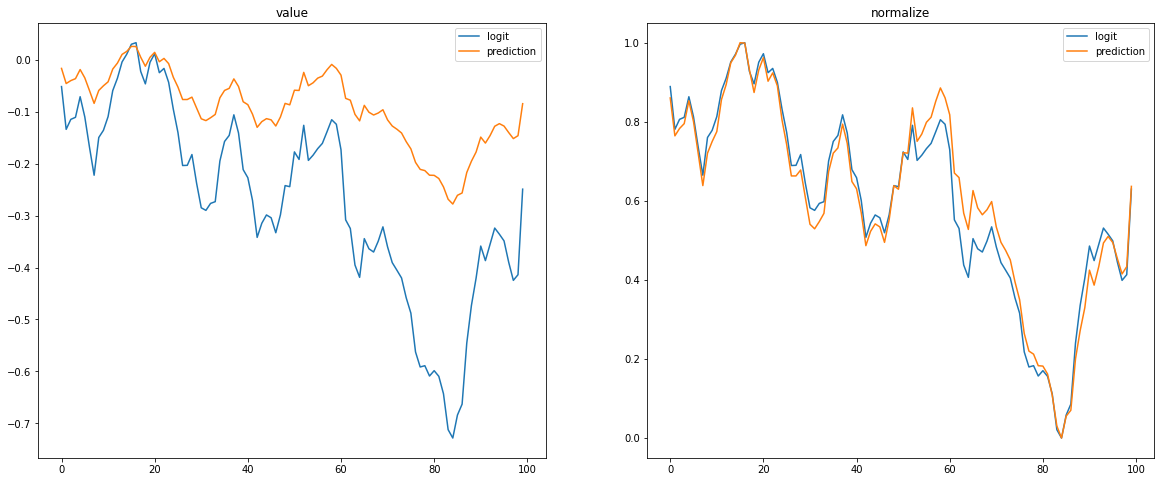

In [30]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_title('value')
ax1.plot(logit_score_mean, label='logit')
ax1.plot(pred_score_mean, label='prediction')
ax1.legend()

ax2.set_title('normalize')
ax2.plot(logit_score_norm, label='logit')
ax2.plot(pred_score_norm, label='prediction')
ax2.legend()

### 別の方法で平均化

- window size: N/5 かつ step: 1で平均化
- window size: 2 かつ step: 1で平均化を繰り返す

In [54]:
df.shape

(799, 3)

In [45]:
# windows size:N/5 and step:1
window_size = int(df.shape[0] / 5)
w = np.ones(window_size)/window_size
logit_score_mean2 = np.convolve(df['logit_score'], w, mode='valid')
len(logit_score_mean2)

641

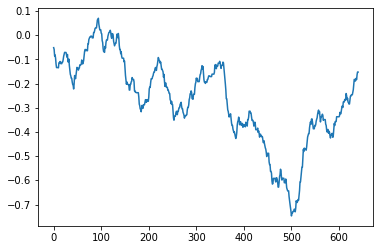

In [46]:
# 描画
plt.plot(logit_score_mean2)

In [61]:
# window_size: 2で固定して100回平均化する関数
def score_mean2(score, iter=100):
    for _ in range(iter):
        window_size = 2
        w = np.ones(window_size)/window_size
        score = np.convolve(score, w, mode='valid')
    
    plt.title(f'length: {len(score)}')
    plt.plot(score)
    plt.show()

    return score

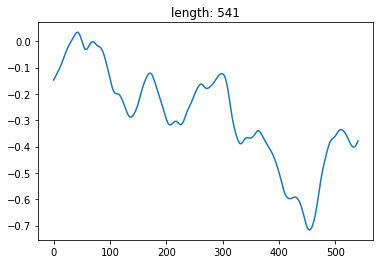

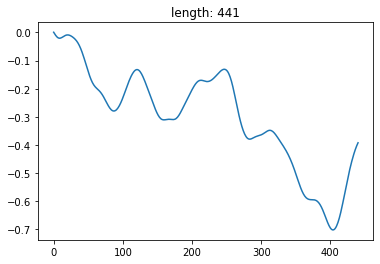

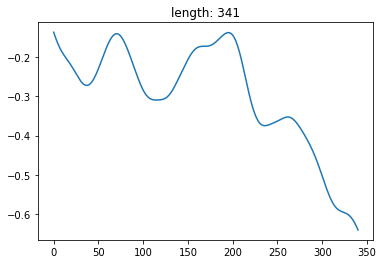

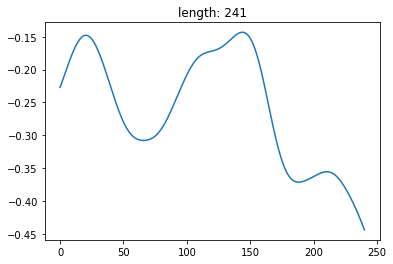

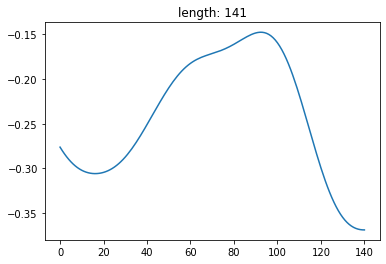

In [62]:
score = logit_score_mean2
for _ in np.arange(5):
    score = score_mean2(score)

形が変わってしまうので，この案はボツ．